In [1]:
import os
import numpy as np
from dotenv import load_dotenv
load_dotenv("ionq.env")

from qiskit_ionq import IonQProvider
from qiskit_ionq import GPIGate, GPI2Gate, MSGate, ZZGate

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import random_clifford, hellinger_fidelity, state_fidelity, Statevector, Operator
from qiskit.transpiler import PassManager, CouplingMap
from qiskit_ibm_transpiler.ai.collection import CollectCliffords
from qiskit_ibm_transpiler.ai.synthesis import AICliffordSynthesis

from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = dict(qc.count_ops())
    num_multi_qubit_ops = qc.num_nonlocal_gates()
    return {"depth": depth, "num_qubits": num_qubits, "ops": ops, "num_multi_qubit_ops": num_multi_qubit_ops}

# print quantum circuit characteristics
def print_qc_characteristics(qc):
    characteristics = get_qc_characteristics(qc)
    print("Quantum circuit characteristics")
    print("  Depth:", characteristics["depth"])
    print("  Number of qubits:", characteristics["num_qubits"])
    print("  Operations:", characteristics["ops"])
    print(f"  Gate counts: ('1q': {sum(characteristics["ops"].values())-characteristics["num_multi_qubit_ops"]}, '2q': {characteristics["num_multi_qubit_ops"]})")

In [3]:
# Get the backends for IonQ simulators
my_api_key = os.getenv("IONQ_API_KEY")
provider = IonQProvider(my_api_key)

simulator_perfect = provider.get_backend("simulator")
simulator_perfect_native_gates = provider.get_backend("simulator", gateset="native")

simulator_noisy = provider.get_backend("simulator")
simulator_noisy.set_options(noise_model="aria-1")
simulator_noisy_native_gates = provider.get_backend("simulator", gateset="native")
simulator_noisy_native_gates.set_options(noise_model="aria-1")

In [4]:
# Available gates
print(simulator_perfect.gateset())
print(simulator_perfect_native_gates.gateset())

qis
native


Quantum circuit characteristics
  Depth: 64
  Number of qubits: 5
  Operations: {'cx': 33, 's': 30, 'h': 28, 't': 15, 'swap': 5, 'z': 5, 'x': 5, 'measure': 5, 'y': 4, 'barrier': 1}
  Gate counts: ('1q': 93, '2q': 38)


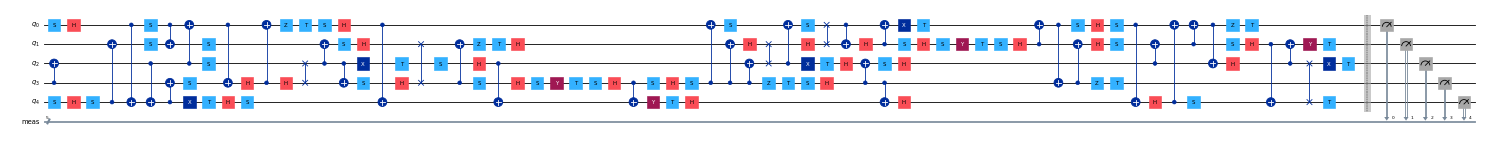

In [5]:
# make the circuit
nq = 5
circuit = QuantumCircuit(nq)

for c in range(3):
    qs = np.random.choice(range(circuit.num_qubits), size=nq, replace=False)
    circuit.compose(random_clifford(nq).to_circuit(), qubits=qs.tolist(), inplace=True)
    for q in qs:
        circuit.t(q)

circuit.measure_all()

print_qc_characteristics(circuit)
circuit.draw(output="mpl", fold=-1, scale=0.3, style="iqp", idle_wires=False)

Transpiled circuit using Qiskit
Quantum circuit characteristics
  Depth: 161
  Number of qubits: 5
  Operations: {'gpi2': 286, 'gpi': 83, 'ms': 30, 'measure': 5, 'barrier': 1}
  Gate counts: ('1q': 375, '2q': 30)


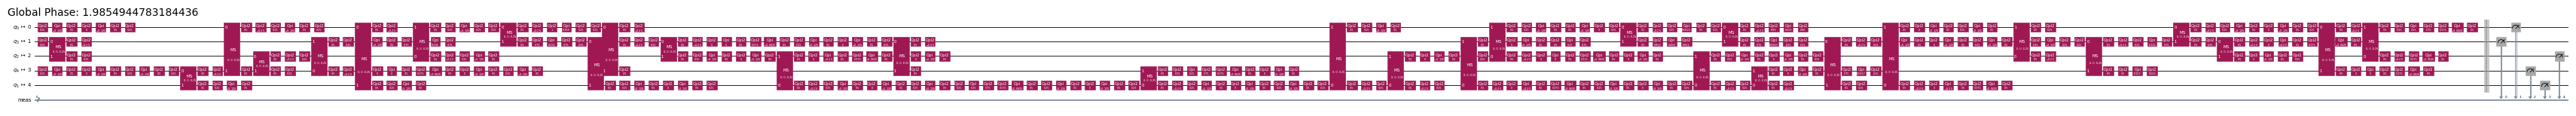

'\nprint("AI optimized circuit using Qiskit")\nai_optimize_cliffords = PassManager(\n    [\n        CollectCliffords(min_block_size=3, max_block_size=8),\n        AICliffordSynthesis(backend=simulator_perfect_native_gates),\n    ]\n)\n# AI Synthesis passes respect the coupling map and should run after transpiling\nai_optimized_circuit = ai_optimize_cliffords.run(transpiled_circuit)\nprint_qc_characteristics(ai_optimized_circuit)\nai_optimized_circuit.draw(output="mpl", fold=-1, scale=0.25, style="iqp", idle_wires=False)\n'

In [6]:
print("Transpiled circuit using Qiskit")
transpiled_circuit = transpile(
    circuit, 
    backend=simulator_perfect_native_gates,
    optimization_level=3,
    coupling_map=CouplingMap.from_full(nq),
)
print_qc_characteristics(transpiled_circuit)
display(transpiled_circuit.draw(output="mpl", fold=-1, scale=0.3, style="iqp", idle_wires=False))

"""
print("AI optimized circuit using Qiskit")
ai_optimize_cliffords = PassManager(
    [
        CollectCliffords(min_block_size=3, max_block_size=8),
        AICliffordSynthesis(backend=simulator_perfect_native_gates),
    ]
)
# AI Synthesis passes respect the coupling map and should run after transpiling
ai_optimized_circuit = ai_optimize_cliffords.run(transpiled_circuit)
print_qc_characteristics(ai_optimized_circuit)
ai_optimized_circuit.draw(output="mpl", fold=-1, scale=0.25, style="iqp", idle_wires=False)
"""

In [7]:
job_perfect = simulator_perfect.run(circuit, shots=10000)
job_perfect_counts = job_perfect.get_counts()

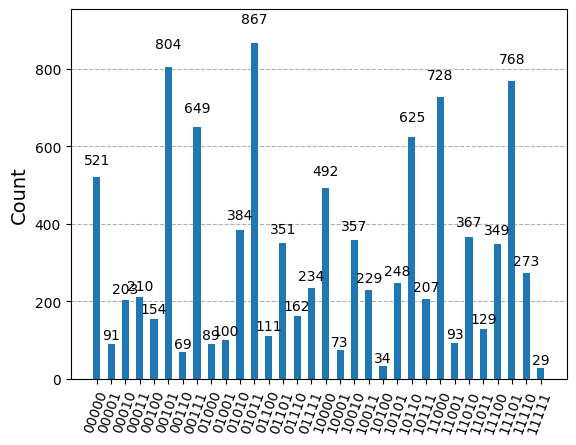

In [8]:
plot_histogram(job_perfect_counts)

In [9]:
job_noisy = simulator_noisy.run(circuit, shots=10000)
job_noisy_counts = job_noisy.get_counts()

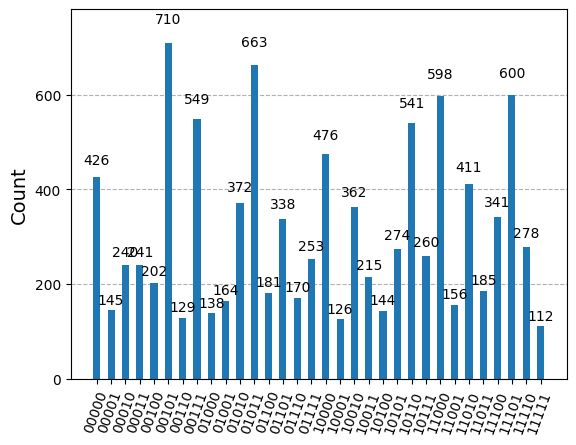

In [10]:
plot_histogram(job_noisy_counts)

In [11]:
job_noisy_qiskit_transpiled = simulator_noisy_native_gates.run(transpiled_circuit, shots=10000)
job_noisy_qiskit_transpiled_counts = job_noisy_qiskit_transpiled.get_counts()

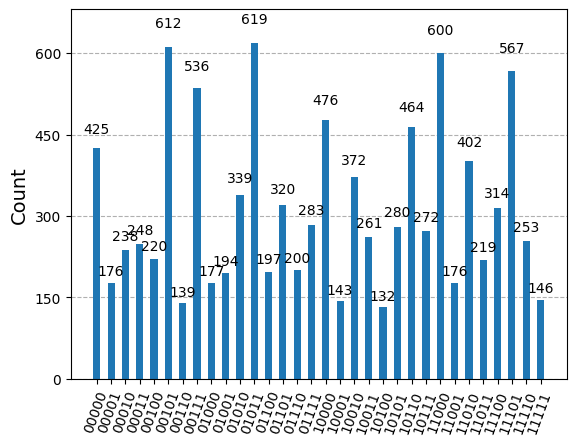

In [12]:
plot_histogram(job_noisy_qiskit_transpiled_counts)

In [13]:
print("IonQ transpiler fidelity:", round(hellinger_fidelity(job_noisy_counts, job_perfect_counts), 4))
print("Qiskit transpiler fidelity:", round(hellinger_fidelity(job_noisy_qiskit_transpiled_counts, job_perfect_counts), 4))

IonQ transpiler fidelity: 0.9821
Qiskit transpiler fidelity: 0.9718


In [14]:
# GPIGate, GPI2Gate, MSGate, ZZGate

sv = Statevector.from_label('0'*nq)

ops = []

for gate in transpiled_circuit.data:

    op = 0 * Operator.from_label('I' * nq)

    if gate[0].name=="gpi":
        op = op._add(Operator(GPIGate(gate[0].params[0]).to_matrix()), qargs=[gate[1][0]._index])
        ops.append(op)
        sv = sv.evolve(op)
    elif gate[0].name=="gpi2":
        op = op._add(Operator(GPI2Gate(gate[0].params[0]).to_matrix()), qargs=[gate[1][0]._index])
        ops.append(op)
        sv = sv.evolve(op)
    elif gate[0].name=="ms":
        op = op._add(Operator(MSGate(gate[0].params[0],gate[0].params[1],gate[0].params[2]).to_matrix()), qargs=[gate[1][0]._index,gate[1][1]._index])
        ops.append(op)
        sv = sv.evolve(op)

    #break

print(sv)

Statevector([ 1.87238085e-01-1.39402656e-01j,
             -6.76495125e-02-1.29495614e-01j,
              8.16601853e-02-4.78354290e-02j,
             -1.39402656e-01+2.39177145e-02j,
              9.15672270e-02+2.07052169e-01j,
              1.49309698e-01-1.15484942e-01j,
             -6.76495125e-02+3.38247563e-02j,
             -4.37317980e-02+1.39402656e-01j,
             -9.90704174e-03-1.25391983e-01j,
             -8.16601853e-02+4.64905892e-16j,
             -1.15484942e-01+2.64794639e-01j,
              2.40876925e-01+5.77424708e-02j,
              5.77424708e-02+9.90704174e-03j,
              1.29495614e-01-2.11155800e-01j,
              1.63320371e-01-1.40106728e-02j,
              1.05577900e-01-1.05577900e-01j,
              8.16601853e-02+4.78354290e-02j,
              7.17531436e-02-1.87238085e-01j,
              7.17531436e-02-7.17531436e-02j,
             -2.92815985e-01+1.94289029e-16j,
             -1.94289029e-16+2.64794639e-01j,
              2.39177145e-02+2.070

In [15]:
sv_after = sv.copy()
for op in ops[::-1]:
    sv_after = sv_after.evolve(Operator(np.linalg.inv(op.to_matrix())))

print(sv_after)

Statevector([ 1.00000000e+00+1.48373104e-16j,
              0.00000000e+00+6.98684814e-17j,
              2.33739590e-16+3.03409822e-16j,
              4.90653893e-17-4.56308121e-16j,
              2.77555756e-17+2.22044605e-16j,
             -6.93889390e-18+2.22044605e-16j,
             -1.94289029e-16-3.88578059e-16j,
             -3.53270803e-16+2.01168096e-16j,
              4.87484826e-16-9.42839203e-17j,
              4.30211422e-16-2.56739074e-16j,
             -2.74086309e-16+5.20417043e-17j,
             -1.21430643e-16+1.04083409e-17j,
              2.45038077e-16-1.24900090e-16j,
              4.09394740e-16-1.94289029e-16j,
              2.94902991e-16+2.04697370e-16j,
              1.56125113e-16+3.15719673e-16j,
             -6.86915451e-17-2.25700791e-16j,
             -7.63278329e-17+5.27355937e-16j,
              3.12250226e-17+1.35308431e-16j,
             -5.65519853e-16-4.33680869e-16j,
             -2.45326947e-16+2.94392336e-17j,
              5.55111512e-17-3.469

In [16]:
fidelity = state_fidelity(Statevector.from_label('0'*nq), sv_after)
print("State Fidelity:", fidelity)

State Fidelity: 0.9999999999999856
